In [1]:
from pyspark.sql import SparkSession

In [2]:
# Spark session & context
spark = SparkSession.builder.master('local').getOrCreate()
sc = spark.sparkContext

In [3]:
sc

<SparkContext master=local appName=pyspark-shell>

In [4]:
data = spark.read.format('csv').option('header', True).load('datasets/london_crime_by_lsoa.csv')

In [5]:
data.printSchema()

root
 |-- lsoa_code: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- major_category: string (nullable = true)
 |-- minor_category: string (nullable = true)
 |-- value: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)



In [6]:
data.show(5)

+---------+----------+--------------------+--------------------+-----+----+-----+
|lsoa_code|   borough|      major_category|      minor_category|value|year|month|
+---------+----------+--------------------+--------------------+-----+----+-----+
|E01001116|   Croydon|            Burglary|Burglary in Other...|    0|2016|   11|
|E01001646| Greenwich|Violence Against ...|      Other violence|    0|2016|   11|
|E01000677|   Bromley|Violence Against ...|      Other violence|    0|2015|    5|
|E01003774| Redbridge|            Burglary|Burglary in Other...|    0|2016|    3|
|E01004563|Wandsworth|             Robbery|   Personal Property|    0|2008|    6|
+---------+----------+--------------------+--------------------+-----+----+-----+
only showing top 5 rows



In [7]:
data.count()

13490604

In [8]:
data.dropna()

DataFrame[lsoa_code: string, borough: string, major_category: string, minor_category: string, value: string, year: string, month: string]

In [9]:
data = data.drop('lsoa_code')

In [10]:
total_borough = data.select('borough').distinct()
total_borough.show(5)

+--------------------+
|             borough|
+--------------------+
|             Croydon|
|          Wandsworth|
|              Bexley|
|             Lambeth|
|Barking and Dagenham|
+--------------------+
only showing top 5 rows



In [11]:
croydon_reports = data.filter(data['borough']=='Croydon').limit(5)
croydon_reports.show()

+-------+--------------------+--------------------+-----+----+-----+
|borough|      major_category|      minor_category|value|year|month|
+-------+--------------------+--------------------+-----+----+-----+
|Croydon|            Burglary|Burglary in Other...|    0|2016|   11|
|Croydon|               Drugs| Possession Of Drugs|    0|2010|   12|
|Croydon|  Theft and Handling|         Other Theft|    1|2014|    5|
|Croydon|Violence Against ...|    Offensive Weapon|    0|2012|   12|
|Croydon|               Drugs|    Drug Trafficking|    0|2008|    2|
+-------+--------------------+--------------------+-----+----+-----+



In [12]:
count_of_cases_from_14_to_16 = data.filter(data['year'].isin([2014, 2015, 2016]))
count_of_cases_from_14_to_16.count()

4496868

In [13]:
count_of_cases_from_14_to_16.sample(0.1).show()

+--------------------+--------------------+--------------------+-----+----+-----+
|             borough|      major_category|      minor_category|value|year|month|
+--------------------+--------------------+--------------------+-----+----+-----+
|             Croydon|            Burglary|Burglary in Other...|    0|2016|   11|
|           Redbridge|            Burglary|Burglary in Other...|    0|2016|    3|
|              Barnet|Violence Against ...|          Harassment|    1|2014|    1|
|           Southwark|  Theft and Handling|         Other Theft|    1|2014|   12|
|               Brent|Violence Against ...| Assault with Injury|    1|2014|    9|
|              Newham|Violence Against ...|          Harassment|    0|2015|    8|
|             Lambeth|     Criminal Damage|Criminal Damage T...|    0|2016|    7|
|            Havering|Violence Against ...|          Harassment|    1|2016|    8|
|             Enfield|  Theft and Handling|Motor Vehicle Int...|    1|2015|    7|
|             En

In [14]:
borough_grouped_convictions_sum = data.groupby('borough') \
    .agg({"value": "sum"}) \
    .withColumnRenamed('sum(value)', 'convinctions')
borough_grouped_convictions_sum.show(10)

+--------------------+------------+
|             borough|convinctions|
+--------------------+------------+
|             Croydon|    260294.0|
|          Wandsworth|    204741.0|
|              Bexley|    114136.0|
|             Lambeth|    292178.0|
|Barking and Dagenham|    149447.0|
|              Camden|    275147.0|
|           Greenwich|    181568.0|
|              Newham|    262024.0|
|       Tower Hamlets|    228613.0|
|            Hounslow|    186772.0|
+--------------------+------------+
only showing top 10 rows



In [15]:
total_number_of_convictions = borough_grouped_convictions_sum.agg({'convinctions': 'sum'})
total_number_of_convictions.show()
total_number_of_convictions_value = total_number_of_convictions.collect()[0][0]

+-----------------+
|sum(convinctions)|
+-----------------+
|        6447758.0|
+-----------------+



In [16]:
total_number_of_convictions_value

6447758.0

In [17]:
import pyspark.sql.functions as func

In [18]:
borough_percent_contribution = borough_grouped_convictions_sum \
    .withColumn('% contrib', func.round(borough_grouped_convictions_sum.convinctions / total_number_of_convictions_value * 100, 2)) 

Borough with highest to lowest crimes

In [19]:
borough_percent_contribution.sort('% contrib', ascending=False).show(5)

+-----------+------------+---------+
|    borough|convinctions|% contrib|
+-----------+------------+---------+
|Westminster|    455028.0|     7.06|
|    Lambeth|    292178.0|     4.53|
|  Southwark|    278809.0|     4.32|
|     Camden|    275147.0|     4.27|
|     Newham|    262024.0|     4.06|
+-----------+------------+---------+
only showing top 5 rows



In [20]:
monthly_crime_report_in_2014 = data.filter(data.year == 2014)\
    .groupBy('month')\
    .agg({'value' : 'sum'}) \
    .withColumnRenamed('sum(value)', 'convictions') \
    .sort('convictions', ascending=False)

monthly_crime_report_in_2014.show()

+-----+-----------+
|month|convictions|
+-----+-----------+
|   10|    60537.0|
|   11|    59704.0|
|    7|    58564.0|
|    3|    57669.0|
|   12|    57565.0|
|    6|    57039.0|
|    9|    56933.0|
|    5|    56327.0|
|    8|    55641.0|
|    1|    55515.0|
|    4|    53467.0|
|    2|    51222.0|
+-----+-----------+



In [24]:
data.crosstab('borough', 'major_category') \
    .select('borough_major_category', 'Robbery', 'Fraud or Forgery', 'Drugs').show()

+----------------------+-------+----------------+-----+
|borough_major_category|Robbery|Fraud or Forgery|Drugs|
+----------------------+-------+----------------+-----+
|              Havering|  27648|            5508|32616|
|                Merton|  23652|            5724|29160|
|              Haringey|  29484|           10368|35424|
|         Tower Hamlets|  28512|            5400|37368|
|               Bromley|  34668|            8532|42336|
|               Enfield|  35532|            9720|44064|
|  Kingston upon Thames|  15660|            3780|22140|
|           Westminster|  25056|            8748|32616|
|  Richmond upon Thames|  18468|            2808|23004|
|              Lewisham|  34884|           11016|43740|
|                 Brent|  34128|            9288|46980|
|  Barking and Dagenham|  22248|            7236|26244|
|             Redbridge|  32400|            8532|36504|
|             Islington|  26244|            5184|34128|
|               Hackney|  29160|            7560

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
plt.style.use('ggplot')

In [39]:
def yearly_report(year):
    report = data.filter(data.year == year).groupBy('borough') \
        .agg({'value':'sum'}) \
        .withColumnRenamed('sum(value)', 'convictions')
    boroughs = [x[0] for x in report.toLocalIterator()]
    convictions = [x[1] for x in report.toLocalIterator()]
    plt.figure(figsize=(33,10))
    plt.title(f'Crime report for year {year}')
    plt.xlabel('Boroughs')
    plt.ylabel('Convictions')
    plt.bar(boroughs, convictions)
    plt.xticks(rotation=90)
    plt.autoscale()
    plt.show()

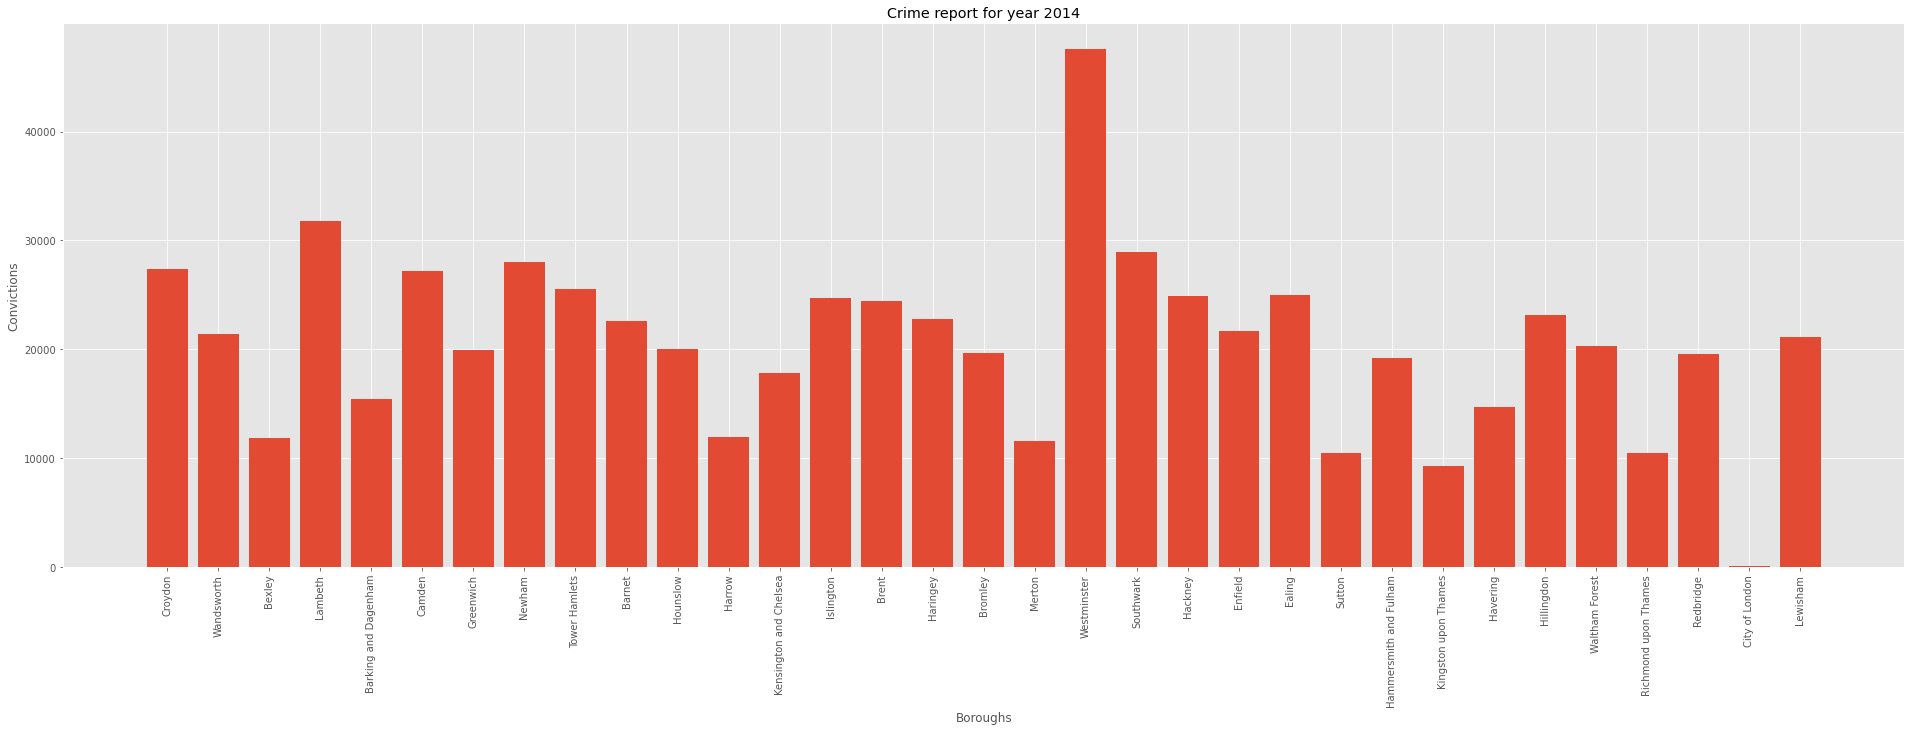

In [40]:
yearly_report(2014)